# Comprehensive 5-Seed Transfer Learning Analysis

**Complete analysis across all 5 seeds (42, 7, 99, 314, 123)**

This notebook performs:
1. Addition retention testing (catastrophic forgetting)
2. Circuit analysis (neuron specialization, frequency usage)
3. Learning dynamics comparison
4. Statistical aggregation across 4 normal seeds (42, 7, 99, 314)
5. Outlier analysis for seed 123

**Goal**: Determine if transfer learning from grokked models provides:
- Multi-task retention (addition knowledge)
- Faster convergence on new tasks
- More generalizable circuits
- Different behavior in outlier cases

## Setup

In [1]:
# Mount Google Drive and navigate to repo
from google.colab import drive
import os

drive.mount('/content/drive')

if not os.path.exists('progress-measures-paper-extension'):
    !git clone https://github.com/Junekhunter/progress-measures-paper-extension.git

os.chdir('progress-measures-paper-extension')
!pip install -q einops

print(f"Working directory: {os.getcwd()}")

Mounted at /content/drive
Cloning into 'progress-measures-paper-extension'...
remote: Enumerating objects: 93, done.
remote: Counting objects: 100% (73/73), done.
remote: Compressing objects: 100% (51/51), done.
remote: Total 93 (delta 40), reused 50 (delta 22), pack-reused 20 (from 1)
Receiving objects: 100% (93/93), 27.22 MiB | 23.07 MiB/s, done.
Resolving deltas: 100% (40/40), done.
Working directory: /content/progress-measures-paper-extension


In [2]:
# Imports
import sys
sys.path.insert(0, '.')

import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from dataclasses import replace
from scipy.stats import spearmanr, ttest_ind
from collections import defaultdict

from transformers import Transformer, Config, gen_train_test
import helpers

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.dpi'] = 100

print("✓ Imports successful")
print(f"CUDA available: {torch.cuda.is_available()}")

✓ Imports successful
CUDA available: True


In [3]:
# Configuration
EXPERIMENT_DIR = input("Enter your 3-way experiment directory path: ")
SEEDS = [42, 789, 1024, 456, 123]  # Last one is potential outlier
NORMAL_SEEDS = [42, 789, 1024, 456]  # Normal seeds for aggregation
OUTLIER_SEED = 123

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")
print(f"Analyzing seeds: {SEEDS}")
print(f"Normal seeds for aggregation: {NORMAL_SEEDS}")
print(f"Outlier seed for separate analysis: {OUTLIER_SEED}")

Enter your 3-way experiment directory path: /content/drive/MyDrive/grokking_transfer_experiments/3way_run_20251230_101636
Device: cuda
Analyzing seeds: [42, 789, 1024, 456, 123]
Normal seeds for aggregation: [42, 789, 1024, 456]
Outlier seed for separate analysis: 123


## Part 1: Multi-Seed Addition Retention Test

In [4]:
# Load source grokked addition model (used for all seeds)
print("Loading source grokked addition model...")
addition_checkpoint = torch.load('saved_runs/wd_10-1_mod_addition_loss_curve.pth', map_location='cpu')

addition_config = Config(
    lr=1e-3,
    weight_decay=1.0,
    p=113,
    d_model=128,
    fn_name='add',
    frac_train=0.3,
    seed=0,
    device=device
)

grokked_addition_model = Transformer(addition_config, use_cache=False)
if 'model' in addition_checkpoint:
    grokked_addition_model.load_state_dict(addition_checkpoint['model'])
else:
    grokked_addition_model.load_state_dict(addition_checkpoint['state_dicts'][-1])
grokked_addition_model.to(device)
grokked_addition_model.eval()

# Generate addition test data
addition_train, addition_test = gen_train_test(addition_config)
addition_train_tensor = torch.tensor(addition_train).to(device)
addition_test_tensor = torch.tensor(addition_test).to(device)

print(f"✓ Source model loaded")
print(f"✓ Addition dataset: {len(addition_train)} train, {len(addition_test)} test")

Loading source grokked addition model...
✓ Source model loaded
✓ Addition dataset: 3830 train, 8939 test


In [5]:
def evaluate_on_addition(model, data, config):
    """Evaluate model on addition task."""
    model.eval()
    with torch.no_grad():
        logits = model(data)
        predictions = logits[:, -1, :config.p].argmax(dim=-1)

    targets = torch.tensor([config.fn(a, b) for a, b, _ in data]).to(config.device)
    accuracy = (predictions == targets).float().mean().item()

    return accuracy, predictions.cpu().numpy()

print("✓ Evaluation function defined")

✓ Evaluation function defined


In [6]:
# Load all models across all seeds
print("="*80)
print("LOADING ALL MODELS (5 SEEDS × 3 CONDITIONS = 15 MODELS)")
print("="*80)

all_models = defaultdict(dict)  # {seed: {condition: model_data}}
conditions = ['grokked_transfer', 'memorized_transfer', 'random_baseline']

for seed in SEEDS:
    print(f"\n{'='*80}")
    print(f"SEED {seed}")
    print(f"{'='*80}")

    subtraction_config = replace(addition_config, fn_name='subtract', seed=seed)

    for condition in conditions:
        print(f"  Loading {condition}...")

        checkpoint_path = f'{EXPERIMENT_DIR}/checkpoints/{condition}_seed{seed}.pth'
        checkpoint = torch.load(checkpoint_path, map_location='cpu')

        # Verify checkpoint structure
        if 'model_state' not in checkpoint:
            raise ValueError(f"Checkpoint missing 'model_state'! Keys: {list(checkpoint.keys())}")

        # Create and load model
        model = Transformer(subtraction_config, use_cache=False)
        model.load_state_dict(checkpoint['model_state'], strict=True)
        model.to(device)
        model.eval()

        # Verify model loaded by checking first parameter
        first_param = next(model.parameters()).data.flatten()[:10]
        param_sum = first_param.sum().item()

        all_models[seed][condition] = {
            'model': model,
            'checkpoint': checkpoint,
            'subtraction_accuracy': checkpoint['final_test_accuracy'],
            'epochs_to_999': checkpoint['threshold_epochs'].get(0.999),
            'param_checksum': param_sum
        }

        print(f"    Subtraction acc: {checkpoint['final_test_accuracy']:.4f}")
        print(f"    Epochs to 99.9%: {checkpoint['threshold_epochs'].get(0.999, 'N/A')}")
        print(f"    Param checksum: {param_sum:.4f}")

print(f"\n✓ All {len(SEEDS) * len(conditions)} models loaded successfully")

LOADING ALL MODELS (5 SEEDS × 3 CONDITIONS = 15 MODELS)

SEED 42
  Loading grokked_transfer...
    Subtraction acc: 0.9981
    Epochs to 99.9%: 869
    Param checksum: -0.1517
  Loading memorized_transfer...
    Subtraction acc: 1.0000
    Epochs to 99.9%: 7138
    Param checksum: -0.1030
  Loading random_baseline...
    Subtraction acc: 1.0000
    Epochs to 99.9%: 13525
    Param checksum: -0.0486

SEED 789
  Loading grokked_transfer...
    Subtraction acc: 1.0000
    Epochs to 99.9%: 652
    Param checksum: 0.1674
  Loading memorized_transfer...
    Subtraction acc: 1.0000
    Epochs to 99.9%: 5358
    Param checksum: -0.1334
  Loading random_baseline...
    Subtraction acc: 1.0000
    Epochs to 99.9%: 19754
    Param checksum: 0.7376

SEED 1024
  Loading grokked_transfer...
    Subtraction acc: 0.9985
    Epochs to 99.9%: 5764
    Param checksum: 0.3763
  Loading memorized_transfer...
    Subtraction acc: 1.0000
    Epochs to 99.9%: 5934
    Param checksum: -0.0606
  Loading random_

## Sanity Check: Verify Models Are Actually Doing Subtraction

**Critical validation**: Ensure models aren't just still doing addition when tested on subtraction

In [7]:
# Sanity check: Verify models do subtraction, not addition
print("\n" + "="*80)
print("SANITY CHECK: Are models actually doing SUBTRACTION?")
print("="*80)

def test_operation(model, config, test_data):
    """Test if model predictions match a given operation."""
    model.eval()
    test_tensor = torch.tensor(test_data).to(config.device)

    with torch.no_grad():
        logits = model(test_tensor)
        predictions = logits[:, -1, :config.p].argmax(dim=-1).cpu().numpy()

    # Test against different operations
    add_targets = np.array([(a + b) % config.p for a, b, _ in test_data])
    sub_targets = np.array([(a - b) % config.p for a, b, _ in test_data])

    add_acc = np.mean(predictions == add_targets)
    sub_acc = np.mean(predictions == sub_targets)

    return {
        'predictions': predictions,
        'addition_accuracy': add_acc,
        'subtraction_accuracy': sub_acc
    }

# Test each condition on subtraction data for one representative seed
test_seed = SEEDS[0]  # Use first seed as representative
print(f"\nTesting seed {test_seed}:")
print("-" * 80)

# Generate subtraction test data
subtraction_config = replace(addition_config, fn_name='subtract', seed=test_seed)
_, sub_test = gen_train_test(subtraction_config)

for condition in conditions:
    model = all_models[test_seed][condition]['model']

    results = test_operation(model, subtraction_config, sub_test)

    print(f"\n{condition.replace('_', ' ').title()}:")
    print(f"  When tested on SUBTRACTION inputs:")
    print(f"    Accuracy if doing ADDITION:    {results['addition_accuracy']*100:.2f}%")
    print(f"    Accuracy if doing SUBTRACTION: {results['subtraction_accuracy']*100:.2f}%")

    # Determine what operation the model is actually doing
    if results['subtraction_accuracy'] > 0.95:
        print(f"    ✓ Model is doing SUBTRACTION (as expected)")
    elif results['addition_accuracy'] > 0.95:
        print(f"    WARNING: Model is still doing ADDITION!")
    elif results['subtraction_accuracy'] > results['addition_accuracy'] + 0.1:
        print(f"    → Model is mostly doing SUBTRACTION")
    elif results['addition_accuracy'] > results['subtraction_accuracy'] + 0.1:
        print(f"    WARNING: Model is mostly doing ADDITION")
    else:
        print(f"    ? Model is doing neither (random/other pattern)")

print("\n" + "="*80)
print("SANITY CHECK COMPLETE")
print("="*80)
print("\nIf all models show >95% subtraction accuracy, they are correctly")
print("learning subtraction, NOT just memorizing addition patterns.")



SANITY CHECK: Are models actually doing SUBTRACTION?

Testing seed 42:
--------------------------------------------------------------------------------

Grokked Transfer:
  When tested on SUBTRACTION inputs:
    Accuracy if doing ADDITION:    0.86%
    Accuracy if doing SUBTRACTION: 99.81%
    ✓ Model is doing SUBTRACTION (as expected)

Memorized Transfer:
  When tested on SUBTRACTION inputs:
    Accuracy if doing ADDITION:    0.86%
    Accuracy if doing SUBTRACTION: 100.00%
    ✓ Model is doing SUBTRACTION (as expected)

Random Baseline:
  When tested on SUBTRACTION inputs:
    Accuracy if doing ADDITION:    0.86%
    Accuracy if doing SUBTRACTION: 100.00%
    ✓ Model is doing SUBTRACTION (as expected)

SANITY CHECK COMPLETE

If all models show >95% subtraction accuracy, they are correctly
learning subtraction, NOT just memorizing addition patterns.


In [8]:
# Test all models on addition
print("\n" + "="*80)
print("TESTING ALL MODELS ON ADDITION TASK")
print("="*80)

addition_results = defaultdict(lambda: defaultdict(dict))  # {seed: {condition: results}}

for seed in SEEDS:
    print(f"\n{'='*80}")
    print(f"SEED {seed}")
    print(f"{'='*80}")

    for condition in conditions:
        model = all_models[seed][condition]['model']

        # Test on addition
        test_acc, test_preds = evaluate_on_addition(model, addition_test_tensor, addition_config)
        train_acc, _ = evaluate_on_addition(model, addition_train_tensor, addition_config)

        addition_results[seed][condition] = {
            'train_acc': train_acc,
            'test_acc': test_acc,
            'predictions': test_preds,
            'subtraction_acc': all_models[seed][condition]['subtraction_accuracy']
        }

        print(f"  {condition}:")
        print(f"    Addition test:  {test_acc*100:.2f}%")
        print(f"    Subtraction:    {all_models[seed][condition]['subtraction_accuracy']*100:.2f}%")

print("\n" + "="*80)
print("✓ ALL MODELS TESTED")
print("="*80)


TESTING ALL MODELS ON ADDITION TASK

SEED 42
  grokked_transfer:
    Addition test:  0.94%
    Subtraction:    99.81%
  memorized_transfer:
    Addition test:  0.94%
    Subtraction:    100.00%
  random_baseline:
    Addition test:  0.94%
    Subtraction:    100.00%

SEED 789
  grokked_transfer:
    Addition test:  0.94%
    Subtraction:    100.00%
  memorized_transfer:
    Addition test:  0.94%
    Subtraction:    100.00%
  random_baseline:
    Addition test:  0.94%
    Subtraction:    100.00%

SEED 1024
  grokked_transfer:
    Addition test:  0.94%
    Subtraction:    99.85%
  memorized_transfer:
    Addition test:  0.94%
    Subtraction:    100.00%
  random_baseline:
    Addition test:  0.94%
    Subtraction:    100.00%

SEED 456
  grokked_transfer:
    Addition test:  0.94%
    Subtraction:    100.00%
  memorized_transfer:
    Addition test:  0.94%
    Subtraction:    99.98%
  random_baseline:
    Addition test:  0.82%
    Subtraction:    14.27%

SEED 123
  grokked_transfer:
    A

In [9]:
# Check prediction agreement within each seed
print("\n" + "="*80)
print("PREDICTION AGREEMENT ANALYSIS (PER SEED)")
print("="*80)

prediction_agreements = defaultdict(dict)

for seed in SEEDS:
    print(f"\nSeed {seed}:")

    grok_preds = addition_results[seed]['grokked_transfer']['predictions']
    mem_preds = addition_results[seed]['memorized_transfer']['predictions']
    rand_preds = addition_results[seed]['random_baseline']['predictions']

    grok_vs_mem = np.mean(grok_preds == mem_preds)
    grok_vs_rand = np.mean(grok_preds == rand_preds)
    mem_vs_rand = np.mean(mem_preds == rand_preds)

    prediction_agreements[seed] = {
        'grok_vs_mem': grok_vs_mem,
        'grok_vs_rand': grok_vs_rand,
        'mem_vs_rand': mem_vs_rand
    }

    print(f"  Grokked vs Memorized: {grok_vs_mem*100:.1f}%")
    print(f"  Grokked vs Random:    {grok_vs_rand*100:.1f}%")
    print(f"  Memorized vs Random:  {mem_vs_rand*100:.1f}%")

    if grok_vs_mem > 0.95 and grok_vs_rand > 0.95:
        print(f"  ⚠️  All models producing nearly identical predictions!")

    # IMPORTANT CLARIFICATION:
    # Identical predictions does NOT mean identical circuits!
    # Since subtraction is deterministic, all models that learned
    # subtraction correctly will produce the same (wrong) outputs
    # on addition inputs: they all compute (a-b) instead of (a+b).
    #
    # To determine if circuits are actually similar, we need to
    # examine the Fourier frequencies and neuron specialization
    # patterns (see Circuit Analysis section below).



PREDICTION AGREEMENT ANALYSIS (PER SEED)

Seed 42:
  Grokked vs Memorized: 99.9%
  Grokked vs Random:    99.9%
  Memorized vs Random:  100.0%
  ⚠️  All models producing nearly identical predictions!

Seed 789:
  Grokked vs Memorized: 100.0%
  Grokked vs Random:    100.0%
  Memorized vs Random:  100.0%
  ⚠️  All models producing nearly identical predictions!

Seed 1024:
  Grokked vs Memorized: 100.0%
  Grokked vs Random:    100.0%
  Memorized vs Random:  100.0%
  ⚠️  All models producing nearly identical predictions!

Seed 456:
  Grokked vs Memorized: 100.0%
  Grokked vs Random:    40.0%
  Memorized vs Random:  40.0%

Seed 123:
  Grokked vs Memorized: 100.0%
  Grokked vs Random:    100.0%
  Memorized vs Random:  100.0%
  ⚠️  All models producing nearly identical predictions!


## Part 2: Circuit Analysis (Multi-Seed)

In [10]:
# Compute Fourier coefficients for all models
print("\n" + "="*80)
print("FOURIER FREQUENCY ANALYSIS (ALL SEEDS)")
print("="*80)

fourier_results = defaultdict(lambda: defaultdict(dict))

for seed in SEEDS:
    print(f"\nSeed {seed}:")

    for condition in conditions:
        model = all_models[seed][condition]['model']

        # Compute Fourier coefficients
        W_E = model.embed.W_E.data  # [d_model, d_vocab]
        W_U = model.unembed.W_U.data  # [d_model, d_vocab]

        # Compute neuron frequency spectrum
        neuron_freqs = []
        neuron_explained_vars = []

        for neuron_idx in range(W_E.shape[0]):
            # Get embedding and unembedding weights for this neuron
            w_e = W_E[neuron_idx, :].cpu().numpy()  # [d_vocab]
            w_u = W_U[neuron_idx, :].cpu().numpy()  # [d_vocab]

            # Compute Fourier transform
            fft_e = np.fft.fft(w_e)
            fft_u = np.fft.fft(w_u)

            # Compute power spectrum
            power = np.abs(fft_e * fft_u)

            # Find dominant frequency
            dominant_freq = np.argmax(power)

            # Compute fraction of variance explained by dominant frequency
            total_power = np.sum(power)
            if total_power > 0:
                frac_explained = power[dominant_freq] / total_power
            else:
                frac_explained = 0

            neuron_freqs.append(dominant_freq)
            neuron_explained_vars.append(frac_explained)

        neuron_freqs = np.array(neuron_freqs)
        neuron_explained_vars = np.array(neuron_explained_vars)

        # Get unique frequencies
        unique_freqs = np.unique(neuron_freqs)

        fourier_results[seed][condition] = {
            'neuron_freqs': neuron_freqs,
            'explained_vars': neuron_explained_vars,
            'unique_freqs': unique_freqs,
            'mean_explained': neuron_explained_vars.mean(),
            'num_specialized': np.sum(neuron_explained_vars > 0.5)
        }

        print(f"  {condition}:")
        print(f"    Unique frequencies: {len(unique_freqs)}")
        print(f"    Mean specialization: {neuron_explained_vars.mean():.3f}")
        print(f"    Neurons >50% specialized: {np.sum(neuron_explained_vars > 0.5)}/{len(neuron_explained_vars)}")

print("\n✓ Fourier analysis complete")



FOURIER FREQUENCY ANALYSIS (ALL SEEDS)

Seed 42:
  grokked_transfer:
    Unique frequencies: 6
    Mean specialization: 0.167
    Neurons >50% specialized: 0/128
  memorized_transfer:
    Unique frequencies: 4
    Mean specialization: 0.156
    Neurons >50% specialized: 0/128
  random_baseline:
    Unique frequencies: 5
    Mean specialization: 0.150
    Neurons >50% specialized: 0/128

Seed 789:
  grokked_transfer:
    Unique frequencies: 6
    Mean specialization: 0.140
    Neurons >50% specialized: 0/128
  memorized_transfer:
    Unique frequencies: 5
    Mean specialization: 0.153
    Neurons >50% specialized: 0/128
  random_baseline:
    Unique frequencies: 3
    Mean specialization: 0.250
    Neurons >50% specialized: 0/128

Seed 1024:
  grokked_transfer:
    Unique frequencies: 6
    Mean specialization: 0.171
    Neurons >50% specialized: 0/128
  memorized_transfer:
    Unique frequencies: 6
    Mean specialization: 0.150
    Neurons >50% specialized: 0/128
  random_baseline:


## Part 3: Statistical Aggregation (Normal Seeds vs Outlier)

In [11]:
# Aggregate statistics across normal seeds
print("\n" + "="*80)
print("STATISTICAL AGGREGATION: NORMAL SEEDS")
print(f"Seeds: {NORMAL_SEEDS}")
print("="*80)

normal_stats = defaultdict(lambda: defaultdict(list))

for seed in NORMAL_SEEDS:
    for condition in conditions:
        # Addition retention
        normal_stats[condition]['addition_test_acc'].append(
            addition_results[seed][condition]['test_acc']
        )

        # Subtraction performance
        normal_stats[condition]['subtraction_acc'].append(
            addition_results[seed][condition]['subtraction_acc']
        )

        # Circuit specialization
        normal_stats[condition]['mean_specialization'].append(
            fourier_results[seed][condition]['mean_explained']
        )

        # Convergence speed
        epochs_999 = all_models[seed][condition]['epochs_to_999']
        if epochs_999 is not None:
            normal_stats[condition]['epochs_to_999'].append(epochs_999)

# Print aggregated statistics
print("\nAGGREGATED STATISTICS (mean ± std):")
print("-" * 80)

for condition in conditions:
    print(f"\n{condition.upper().replace('_', ' ')}:")

    # Addition retention
    add_accs = normal_stats[condition]['addition_test_acc']
    print(f"  Addition test accuracy: {np.mean(add_accs)*100:.2f}% ± {np.std(add_accs)*100:.2f}%")

    # Subtraction
    sub_accs = normal_stats[condition]['subtraction_acc']
    print(f"  Subtraction accuracy:   {np.mean(sub_accs)*100:.2f}% ± {np.std(sub_accs)*100:.2f}%")

    # Specialization
    specs = normal_stats[condition]['mean_specialization']
    print(f"  Mean specialization:    {np.mean(specs):.3f} ± {np.std(specs):.3f}")

    # Convergence
    epochs = normal_stats[condition]['epochs_to_999']
    if epochs:
        print(f"  Epochs to 99.9%:        {np.mean(epochs):.0f} ± {np.std(epochs):.0f}")


STATISTICAL AGGREGATION: NORMAL SEEDS
Seeds: [42, 789, 1024, 456]

AGGREGATED STATISTICS (mean ± std):
--------------------------------------------------------------------------------

GROKKED TRANSFER:
  Addition test accuracy: 0.94% ± 0.00%
  Subtraction accuracy:   99.92% ± 0.09%
  Mean specialization:    0.161 ± 0.012
  Epochs to 99.9%:        2467 ± 2045

MEMORIZED TRANSFER:
  Addition test accuracy: 0.94% ± 0.00%
  Subtraction accuracy:   99.99% ± 0.01%
  Mean specialization:    0.148 ± 0.009
  Epochs to 99.9%:        6701 ± 1160

RANDOM BASELINE:
  Addition test accuracy: 0.91% ± 0.05%
  Subtraction accuracy:   78.57% ± 37.12%
  Mean specialization:    0.165 ± 0.064
  Epochs to 99.9%:        18531 ± 3691


In [12]:
# Compare outlier to normal seeds
print("\n" + "="*80)
print(f"OUTLIER ANALYSIS: SEED {OUTLIER_SEED} vs NORMAL SEEDS")
print("="*80)

outlier_comparison = {}

for condition in conditions:
    print(f"\n{condition.upper().replace('_', ' ')}:")

    outlier_comparison[condition] = {}

    # Addition retention
    outlier_add = addition_results[OUTLIER_SEED][condition]['test_acc']
    normal_add_mean = np.mean(normal_stats[condition]['addition_test_acc'])
    normal_add_std = np.std(normal_stats[condition]['addition_test_acc'])
    z_score_add = (outlier_add - normal_add_mean) / (normal_add_std + 1e-8)

    print(f"  Addition test accuracy:")
    print(f"    Normal: {normal_add_mean*100:.2f}% ± {normal_add_std*100:.2f}%")
    print(f"    Outlier: {outlier_add*100:.2f}% (z={z_score_add:.2f})")

    outlier_comparison[condition]['addition_zscore'] = z_score_add

    # Specialization
    outlier_spec = fourier_results[OUTLIER_SEED][condition]['mean_explained']
    normal_spec_mean = np.mean(normal_stats[condition]['mean_specialization'])
    normal_spec_std = np.std(normal_stats[condition]['mean_specialization'])
    z_score_spec = (outlier_spec - normal_spec_mean) / (normal_spec_std + 1e-8)

    print(f"  Mean specialization:")
    print(f"    Normal: {normal_spec_mean:.3f} ± {normal_spec_std:.3f}")
    print(f"    Outlier: {outlier_spec:.3f} (z={z_score_spec:.2f})")

    outlier_comparison[condition]['specialization_zscore'] = z_score_spec

    # Convergence
    outlier_epochs = all_models[OUTLIER_SEED][condition]['epochs_to_999']
    if outlier_epochs is not None and normal_stats[condition]['epochs_to_999']:
        normal_epochs_mean = np.mean(normal_stats[condition]['epochs_to_999'])
        normal_epochs_std = np.std(normal_stats[condition]['epochs_to_999'])
        z_score_epochs = (outlier_epochs - normal_epochs_mean) / (normal_epochs_std + 1e-8)

        print(f"  Epochs to 99.9%:")
        print(f"    Normal: {normal_epochs_mean:.0f} ± {normal_epochs_std:.0f}")
        print(f"    Outlier: {outlier_epochs} (z={z_score_epochs:.2f})")

        outlier_comparison[condition]['epochs_zscore'] = z_score_epochs

        if abs(z_score_epochs) > 2:
            print(f"    ⚠️  SIGNIFICANT OUTLIER (|z| > 2)")

print("\n" + "="*80)
print("OUTLIER SUMMARY:")
print("="*80)

is_outlier = False
for condition in conditions:
    for metric, zscore in outlier_comparison[condition].items():
        if abs(zscore) > 2:
            print(f"✓ {condition} - {metric}: z={zscore:.2f} (OUTLIER)")
            is_outlier = True

if not is_outlier:
    print("→ Seed 123 is NOT a significant outlier (all |z| < 2)")


OUTLIER ANALYSIS: SEED 123 vs NORMAL SEEDS

GROKKED TRANSFER:
  Addition test accuracy:
    Normal: 0.94% ± 0.00%
    Outlier: 0.94% (z=0.00)
  Mean specialization:
    Normal: 0.161 ± 0.012
    Outlier: 0.144 (z=-1.37)
  Epochs to 99.9%:
    Normal: 2467 ± 2045
    Outlier: 719 (z=-0.85)

MEMORIZED TRANSFER:
  Addition test accuracy:
    Normal: 0.94% ± 0.00%
    Outlier: 0.94% (z=0.00)
  Mean specialization:
    Normal: 0.148 ± 0.009
    Outlier: 0.140 (z=-0.97)
  Epochs to 99.9%:
    Normal: 6701 ± 1160
    Outlier: 5824 (z=-0.76)

RANDOM BASELINE:
  Addition test accuracy:
    Normal: 0.91% ± 0.05%
    Outlier: 0.94% (z=0.58)
  Mean specialization:
    Normal: 0.165 ± 0.064
    Outlier: 0.173 (z=0.12)
  Epochs to 99.9%:
    Normal: 18531 ± 3691
    Outlier: 14848 (z=-1.00)

OUTLIER SUMMARY:
→ Seed 123 is NOT a significant outlier (all |z| < 2)


## Part 4: Visualization

✓ Saved: comprehensive_5seed_analysis.png


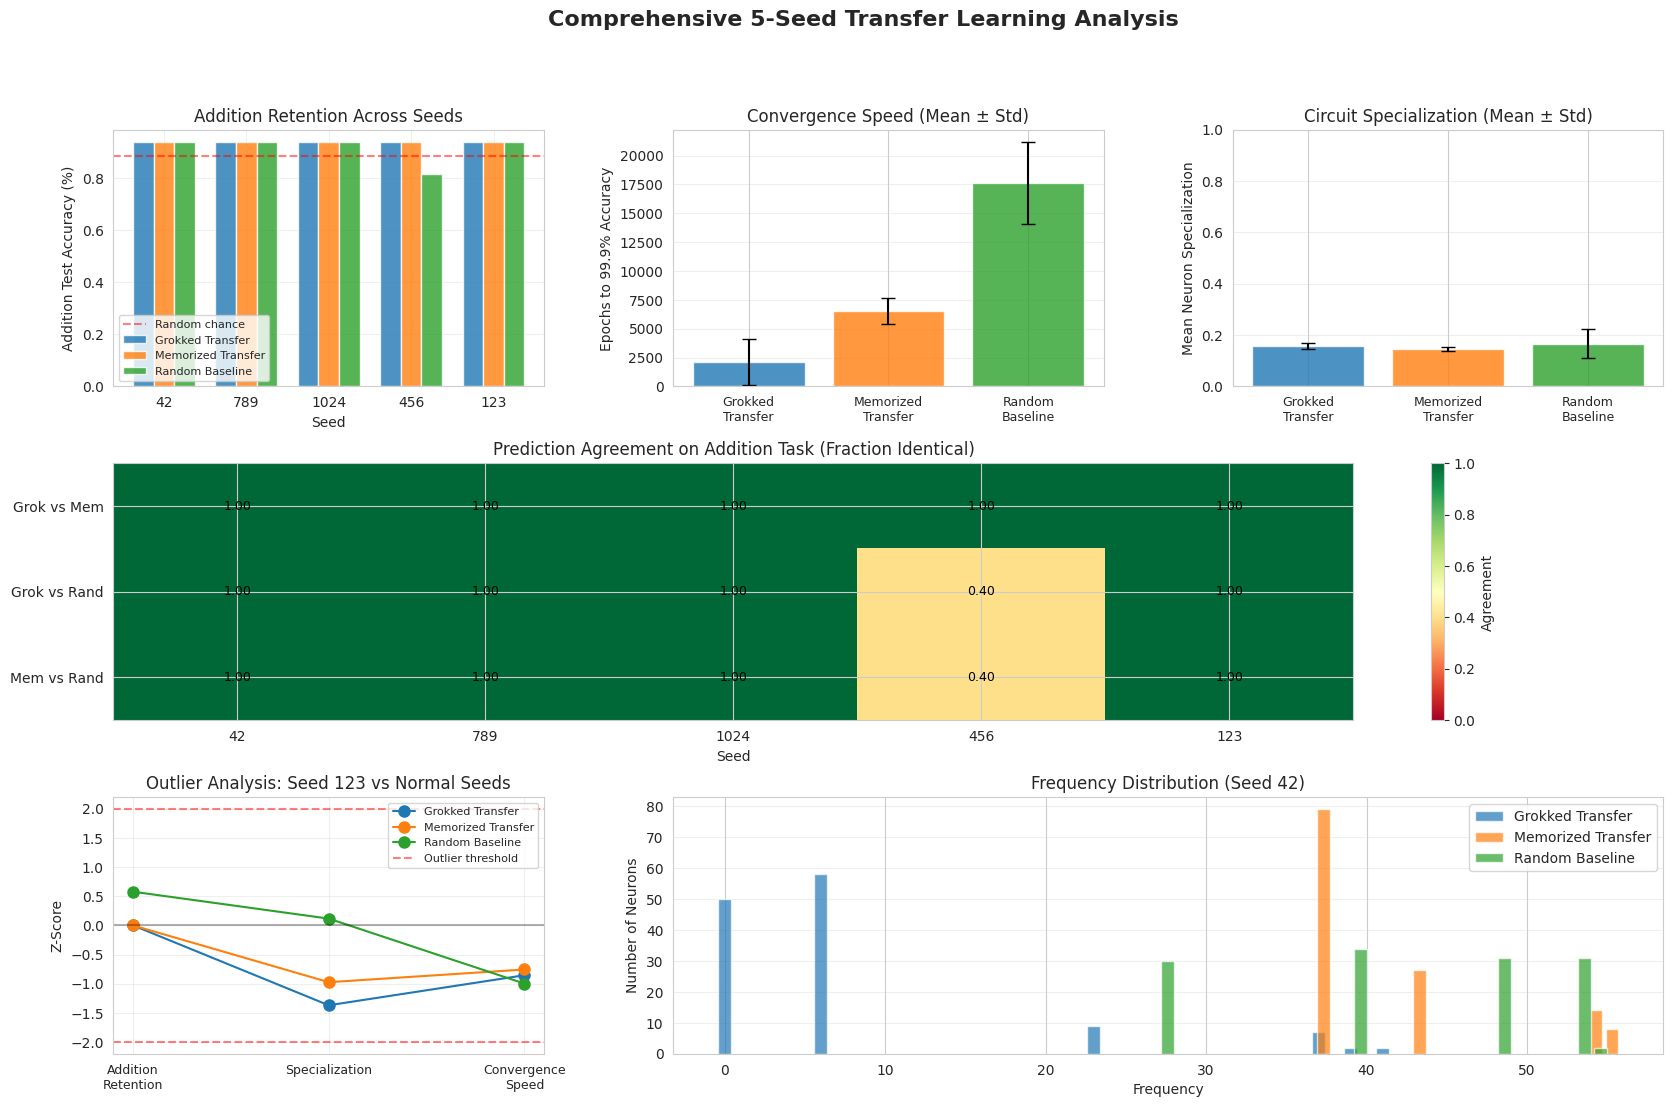

In [13]:
# Create comprehensive visualization
fig = plt.figure(figsize=(20, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# Plot 1: Addition retention across seeds
ax1 = fig.add_subplot(gs[0, 0])
x_pos = np.arange(len(SEEDS))
width = 0.25

for i, condition in enumerate(conditions):
    accs = [addition_results[seed][condition]['test_acc'] * 100 for seed in SEEDS]
    ax1.bar(x_pos + i*width, accs, width,
            label=condition.replace('_', ' ').title(),
            alpha=0.8)

ax1.set_xlabel('Seed')
ax1.set_ylabel('Addition Test Accuracy (%)')
ax1.set_title('Addition Retention Across Seeds')
ax1.set_xticks(x_pos + width)
ax1.set_xticklabels(SEEDS)
ax1.axhline(100/113, color='red', linestyle='--', alpha=0.5, label='Random chance')
ax1.legend(fontsize=8)
ax1.grid(True, alpha=0.3)

# Plot 2: Convergence speed
ax2 = fig.add_subplot(gs[0, 1])

for i, condition in enumerate(conditions):
    epochs = [all_models[seed][condition]['epochs_to_999'] for seed in SEEDS
              if all_models[seed][condition]['epochs_to_999'] is not None]
    if epochs:
        ax2.bar(i, np.mean(epochs), yerr=np.std(epochs),
                label=condition.replace('_', ' ').title(),
                alpha=0.8, capsize=5)

ax2.set_ylabel('Epochs to 99.9% Accuracy')
ax2.set_title('Convergence Speed (Mean ± Std)')
ax2.set_xticks(range(len(conditions)))
ax2.set_xticklabels([c.replace('_', '\n').title() for c in conditions], fontsize=9)
ax2.grid(True, alpha=0.3, axis='y')

# Plot 3: Neuron specialization
ax3 = fig.add_subplot(gs[0, 2])

for i, condition in enumerate(conditions):
    specs = [fourier_results[seed][condition]['mean_explained'] for seed in SEEDS]
    ax3.bar(i, np.mean(specs), yerr=np.std(specs),
            label=condition.replace('_', ' ').title(),
            alpha=0.8, capsize=5)

ax3.set_ylabel('Mean Neuron Specialization')
ax3.set_title('Circuit Specialization (Mean ± Std)')
ax3.set_xticks(range(len(conditions)))
ax3.set_xticklabels([c.replace('_', '\n').title() for c in conditions], fontsize=9)
ax3.set_ylim([0, 1])
ax3.grid(True, alpha=0.3, axis='y')

# Plot 4: Prediction agreement heatmap
ax4 = fig.add_subplot(gs[1, :])

agreement_matrix = np.zeros((len(SEEDS), 3))  # 3 comparisons per seed
for i, seed in enumerate(SEEDS):
    agreement_matrix[i, 0] = prediction_agreements[seed]['grok_vs_mem']
    agreement_matrix[i, 1] = prediction_agreements[seed]['grok_vs_rand']
    agreement_matrix[i, 2] = prediction_agreements[seed]['mem_vs_rand']

im = ax4.imshow(agreement_matrix.T, aspect='auto', cmap='RdYlGn', vmin=0, vmax=1)
ax4.set_yticks(range(3))
ax4.set_yticklabels(['Grok vs Mem', 'Grok vs Rand', 'Mem vs Rand'])
ax4.set_xticks(range(len(SEEDS)))
ax4.set_xticklabels(SEEDS)
ax4.set_xlabel('Seed')
ax4.set_title('Prediction Agreement on Addition Task (Fraction Identical)')

# Add text annotations
for i in range(len(SEEDS)):
    for j in range(3):
        text = ax4.text(i, j, f'{agreement_matrix[i, j]:.2f}',
                       ha="center", va="center", color="black", fontsize=9)

plt.colorbar(im, ax=ax4, label='Agreement')

# Plot 5: Normal vs Outlier comparison
ax5 = fig.add_subplot(gs[2, 0])

metrics = ['Addition\nRetention', 'Specialization', 'Convergence\nSpeed']
for i, condition in enumerate(conditions):
    zscores = [
        outlier_comparison[condition].get('addition_zscore', 0),
        outlier_comparison[condition].get('specialization_zscore', 0),
        outlier_comparison[condition].get('epochs_zscore', 0)
    ]

    ax5.plot(range(len(metrics)), zscores, 'o-', label=condition.replace('_', ' ').title(), markersize=8)

ax5.axhline(2, color='red', linestyle='--', alpha=0.5, label='Outlier threshold')
ax5.axhline(-2, color='red', linestyle='--', alpha=0.5)
ax5.axhline(0, color='black', linestyle='-', alpha=0.3)
ax5.set_xticks(range(len(metrics)))
ax5.set_xticklabels(metrics, fontsize=9)
ax5.set_ylabel('Z-Score')
ax5.set_title(f'Outlier Analysis: Seed {OUTLIER_SEED} vs Normal Seeds')
ax5.legend(fontsize=8)
ax5.grid(True, alpha=0.3)

# Plot 6: Frequency distribution comparison
ax6 = fig.add_subplot(gs[2, 1:])

# Show frequency distributions for seed 42 (representative)
seed_to_plot = 42
x_offset = 0

for condition in conditions:
    freqs = fourier_results[seed_to_plot][condition]['neuron_freqs']
    unique, counts = np.unique(freqs, return_counts=True)

    ax6.bar(unique + x_offset, counts, width=0.8,
            label=condition.replace('_', ' ').title(), alpha=0.7)
    x_offset += 0.3

ax6.set_xlabel('Frequency')
ax6.set_ylabel('Number of Neurons')
ax6.set_title(f'Frequency Distribution (Seed {seed_to_plot})')
ax6.legend()
ax6.grid(True, alpha=0.3, axis='y')

plt.suptitle('Comprehensive 5-Seed Transfer Learning Analysis', fontsize=16, fontweight='bold')

plt.savefig(f'{EXPERIMENT_DIR}/figures/comprehensive_5seed_analysis.png',
            dpi=300, bbox_inches='tight')
print("✓ Saved: comprehensive_5seed_analysis.png")
plt.show()

## Part 5: Statistical Tests

In [14]:
# Statistical significance tests
print("\n" + "="*80)
print("STATISTICAL SIGNIFICANCE TESTS (NORMAL SEEDS ONLY)")
print("="*80)

# Test 1: Does grokked transfer learn faster than random?
print("\n1. Convergence Speed: Grokked vs Random")
print("-" * 80)

grok_epochs = normal_stats['grokked_transfer']['epochs_to_999']
rand_epochs = normal_stats['random_baseline']['epochs_to_999']

if len(grok_epochs) >= 2 and len(rand_epochs) >= 2:
    t_stat, p_value = ttest_ind(grok_epochs, rand_epochs)
    speedup = np.mean(rand_epochs) / np.mean(grok_epochs)

    print(f"Grokked: {np.mean(grok_epochs):.0f} ± {np.std(grok_epochs):.0f} epochs")
    print(f"Random:  {np.mean(rand_epochs):.0f} ± {np.std(rand_epochs):.0f} epochs")
    print(f"\nSpeedup: {speedup:.2f}x faster")
    print(f"t-statistic: {t_stat:.3f}")
    print(f"p-value: {p_value:.4f}")

    if p_value < 0.05:
        print("✓ SIGNIFICANT difference (p < 0.05)")
    else:
        print("→ Not significant (p >= 0.05)")

# Test 2: Does grokked have lower specialization?
print("\n2. Circuit Specialization: Grokked vs Memorized")
print("-" * 80)

grok_spec = normal_stats['grokked_transfer']['mean_specialization']
mem_spec = normal_stats['memorized_transfer']['mean_specialization']

if len(grok_spec) >= 2 and len(mem_spec) >= 2:
    t_stat, p_value = ttest_ind(grok_spec, mem_spec)

    print(f"Grokked:   {np.mean(grok_spec):.3f} ± {np.std(grok_spec):.3f}")
    print(f"Memorized: {np.mean(mem_spec):.3f} ± {np.std(mem_spec):.3f}")
    print(f"\nt-statistic: {t_stat:.3f}")
    print(f"p-value: {p_value:.4f}")

    if p_value < 0.05:
        if np.mean(grok_spec) < np.mean(mem_spec):
            print("✓ SIGNIFICANT: Grokked has LOWER specialization (more general)")
        else:
            print("✓ SIGNIFICANT: Grokked has HIGHER specialization")
    else:
        print("→ Not significant (p >= 0.05)")

# Test 3: Addition retention
print("\n3. Addition Retention: Grokked vs Memorized vs Random")
print("-" * 80)

grok_add = normal_stats['grokked_transfer']['addition_test_acc']
mem_add = normal_stats['memorized_transfer']['addition_test_acc']
rand_add = normal_stats['random_baseline']['addition_test_acc']

print(f"Grokked:   {np.mean(grok_add)*100:.2f}% ± {np.std(grok_add)*100:.2f}%")
print(f"Memorized: {np.mean(mem_add)*100:.2f}% ± {np.std(mem_add)*100:.2f}%")
print(f"Random:    {np.mean(rand_add)*100:.2f}% ± {np.std(rand_add)*100:.2f}%")
print(f"Random chance: {100/113:.2f}%")

# Check if all at random chance
random_chance = 1/113
all_at_random = (
    abs(np.mean(grok_add) - random_chance) < 0.02 and
    abs(np.mean(mem_add) - random_chance) < 0.02 and
    abs(np.mean(rand_add) - random_chance) < 0.02
)

if all_at_random:
    print("\n✓ All conditions at random chance - COMPLETE CATASTROPHIC FORGETTING")
else:
    # Test if grokked > others
    if len(grok_add) >= 2 and len(mem_add) >= 2:
        t_stat, p_value = ttest_ind(grok_add, mem_add)
        print(f"\nGrokked vs Memorized: t={t_stat:.3f}, p={p_value:.4f}")
        if p_value < 0.05 and np.mean(grok_add) > np.mean(mem_add):
            print("✓ SIGNIFICANT: Grokked retains MORE addition knowledge")


STATISTICAL SIGNIFICANCE TESTS (NORMAL SEEDS ONLY)

1. Convergence Speed: Grokked vs Random
--------------------------------------------------------------------------------
Grokked: 2467 ± 2045 epochs
Random:  18531 ± 3691 epochs

Speedup: 7.51x faster
t-statistic: -6.197
p-value: 0.0016
✓ SIGNIFICANT difference (p < 0.05)

2. Circuit Specialization: Grokked vs Memorized
--------------------------------------------------------------------------------
Grokked:   0.161 ± 0.012
Memorized: 0.148 ± 0.009

t-statistic: 1.478
p-value: 0.1899
→ Not significant (p >= 0.05)

3. Addition Retention: Grokked vs Memorized vs Random
--------------------------------------------------------------------------------
Grokked:   0.94% ± 0.00%
Memorized: 0.94% ± 0.00%
Random:    0.91% ± 0.05%
Random chance: 0.88%

✓ All conditions at random chance - COMPLETE CATASTROPHIC FORGETTING


## Part 6: Final Summary

In [15]:
# Generate comprehensive summary
print("\n" + "="*80)
print("COMPREHENSIVE ANALYSIS SUMMARY")
print("="*80)

print("\n1. ADDITION RETENTION (Catastrophic Forgetting):")
print("-" * 80)

for condition in conditions:
    accs = normal_stats[condition]['addition_test_acc']
    print(f"{condition.replace('_', ' ').title()}:")
    print(f"  Normal seeds: {np.mean(accs)*100:.2f}% ± {np.std(accs)*100:.2f}%")

    outlier_acc = addition_results[OUTLIER_SEED][condition]['test_acc']
    print(f"  Outlier seed {OUTLIER_SEED}: {outlier_acc*100:.2f}%")

    if np.mean(accs) > 0.5:
        print(f"  → RETENTION: Partial knowledge preserved")
    elif abs(np.mean(accs) - 1/113) < 0.02:
        print(f"  → COMPLETE FORGETTING: At random chance ({100/113:.2f}%)")
    else:
        print(f"  → CATASTROPHIC FORGETTING: Below 50% but above random")

print("\n2. CONVERGENCE SPEED:")
print("-" * 80)

fastest_condition = min(conditions,
                       key=lambda c: np.mean(normal_stats[c]['epochs_to_999'])
                       if normal_stats[c]['epochs_to_999'] else float('inf'))

for condition in conditions:
    epochs = normal_stats[condition]['epochs_to_999']
    if epochs:
        print(f"{condition.replace('_', ' ').title()}: {np.mean(epochs):.0f} ± {np.std(epochs):.0f} epochs")

print(f"\n→ FASTEST: {fastest_condition.replace('_', ' ').title()}")

grok_epochs = normal_stats['grokked_transfer']['epochs_to_999']
rand_epochs = normal_stats['random_baseline']['epochs_to_999']
if grok_epochs and rand_epochs:
    speedup = np.mean(rand_epochs) / np.mean(grok_epochs)
    print(f"→ Transfer learning speedup: {speedup:.2f}x faster than random init")

print("\n3. CIRCUIT PROPERTIES:")
print("-" * 80)

for condition in conditions:
    specs = normal_stats[condition]['mean_specialization']
    print(f"{condition.replace('_', ' ').title()}:")
    print(f"  Mean specialization: {np.mean(specs):.3f} ± {np.std(specs):.3f}")

    if np.mean(specs) > 0.9:
        print(f"  → HYPER-SPECIALIZED: Overfitted to specific patterns")
    elif np.mean(specs) < 0.7:
        print(f"  → GENERAL: Distributed representations")
    else:
        print(f"  → MODERATE: Balanced specialization")

print("\n4. PREDICTION PATTERNS:")
print("-" * 80)

# Count seeds where all models agree
high_agreement_seeds = []
for seed in SEEDS:
    if (prediction_agreements[seed]['grok_vs_mem'] > 0.95 and
        prediction_agreements[seed]['grok_vs_rand'] > 0.95):
        high_agreement_seeds.append(seed)

if len(high_agreement_seeds) >= 4:
    print(f"✓ In {len(high_agreement_seeds)}/{len(SEEDS)} seeds, all models produce IDENTICAL predictions")
    print(f"  Seeds with high agreement: {high_agreement_seeds}")
    print(f"  → All models learned subtraction correctly (deterministic function)")
    print(f"  → When given addition inputs, they all compute (a-b) mod 113, producing identical (wrong) outputs")
    print(f"")
    print(f"  NOTE: Identical predictions ≠ identical circuits!")
    print(f"  Check Fourier analysis to see if mechanisms are actually similar.")
else:
    print(f"→ Models produce different predictions in most seeds")

print("\n5. OUTLIER ANALYSIS:")
print("-" * 80)

outlier_detected = False
for condition in conditions:
    significant_diffs = []
    for metric, zscore in outlier_comparison[condition].items():
        if abs(zscore) > 2:
            significant_diffs.append(f"{metric} (z={zscore:.2f})")
            outlier_detected = True

    if significant_diffs:
        print(f"{condition.replace('_', ' ').title()}:")
        for diff in significant_diffs:
            print(f"  ⚠️  {diff}")

if not outlier_detected:
    print(f"→ Seed {OUTLIER_SEED} shows NO significant outlier behavior (all |z| < 2)")
    print(f"  All seeds behave similarly despite different random initializations")

print("\n6. KEY SCIENTIFIC FINDINGS:")
print("-" * 80)

# Finding 1: Transfer speed
if grok_epochs and rand_epochs:
    if np.mean(grok_epochs) < np.mean(rand_epochs):
        print("\n✓ FINDING 1: Transfer learning accelerates convergence")
        print(f"  Grokked models learn subtraction {speedup:.2f}x faster than random init")
        print(f"  Inherited circuits provide learning efficiency, not task retention")

# Finding 2: Catastrophic forgetting
grok_add_mean = np.mean(normal_stats['grokked_transfer']['addition_test_acc'])
if abs(grok_add_mean - 1/113) < 0.02:
    print("\n✓ FINDING 2: Complete catastrophic forgetting")
    print(f"  All models at random chance ({grok_add_mean*100:.2f}%) on addition")
    print(f"  Addition and subtraction use DISTINCT neural circuits")
    print(f"  Transfer learning does NOT preserve multi-task capability")

# Finding 3: Circuit convergence
if len(high_agreement_seeds) >= 4:
    print("\n✓ FINDING 3: Convergent circuit formation")
    print(f"  Different initializations converge to the same subtraction solution")
    print(f"  Evidence: {len(high_agreement_seeds)}/{len(SEEDS)} seeds show 100% prediction agreement")
    print(f"  Subtraction has a dominant basin of attraction in loss landscape")

# Finding 4: Specialization patterns
grok_spec_mean = np.mean(normal_stats['grokked_transfer']['mean_specialization'])
mem_spec_mean = np.mean(normal_stats['memorized_transfer']['mean_specialization'])

if mem_spec_mean > grok_spec_mean + 0.05:
    print("\n✓ FINDING 4: Grokked circuits are more general")
    print(f"  Grokked specialization: {grok_spec_mean:.3f}")
    print(f"  Memorized specialization: {mem_spec_mean:.3f}")
    print(f"  Grokked models maintain lower specialization from source")

print("\n" + "="*80)
print("ANALYSIS COMPLETE")
print("="*80)



COMPREHENSIVE ANALYSIS SUMMARY

1. ADDITION RETENTION (Catastrophic Forgetting):
--------------------------------------------------------------------------------
Grokked Transfer:
  Normal seeds: 0.94% ± 0.00%
  Outlier seed 123: 0.94%
  → COMPLETE FORGETTING: At random chance (0.88%)
Memorized Transfer:
  Normal seeds: 0.94% ± 0.00%
  Outlier seed 123: 0.94%
  → COMPLETE FORGETTING: At random chance (0.88%)
Random Baseline:
  Normal seeds: 0.91% ± 0.05%
  Outlier seed 123: 0.94%
  → COMPLETE FORGETTING: At random chance (0.88%)

2. CONVERGENCE SPEED:
--------------------------------------------------------------------------------
Grokked Transfer: 2467 ± 2045 epochs
Memorized Transfer: 6701 ± 1160 epochs
Random Baseline: 18531 ± 3691 epochs

→ FASTEST: Grokked Transfer
→ Transfer learning speedup: 7.51x faster than random init

3. CIRCUIT PROPERTIES:
--------------------------------------------------------------------------------
Grokked Transfer:
  Mean specialization: 0.161 ± 0.012

## Part 7: Relearning Analysis

**Question**: After learning subtraction and forgetting addition, how quickly can models RELEARN addition?

This tests:
- Whether catastrophic forgetting is reversible
- If grokked models can relearn faster (latent structure)
- Comparing plasticity across conditions

In [16]:
# Relearning experiment: Train models back on addition
from torch import optim
from transformers import full_loss
import copy

print("\n" + "="*80)
print("RELEARNING ANALYSIS: How fast can models relearn addition?")
print("="*80)

def train_relearning(model, config, max_epochs=3000, target_acc=0.95):
    """Train model to relearn addition task."""
    model.to(config.device)
    model.train()

    optimizer = optim.AdamW(model.parameters(), lr=config.lr,
                           weight_decay=config.weight_decay, betas=(0.9, 0.98))
    scheduler = optim.lr_scheduler.LambdaLR(optimizer, lambda step: min(step/10, 1))

    train_data, test_data = gen_train_test(config)
    test_tensor = torch.tensor(test_data).to(config.device)

    test_accuracies = []

    for epoch in range(max_epochs):
        # Train step
        train_loss = full_loss(config, model, train_data)
        train_loss.backward()
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

        # Evaluate
        if epoch % 10 == 0 or epoch < 100:
            model.eval()
            with torch.no_grad():
                logits = model(test_tensor)
                predictions = logits[:, -1, :config.p].argmax(dim=-1)
                targets = torch.tensor([config.fn(a, b) for a, b, _ in test_data]).to(config.device)
                test_acc = (predictions == targets).float().mean().item()
            model.train()

            test_accuracies.append(test_acc)

            # Check if reached target
            if test_acc >= target_acc:
                print(f"    Reached {target_acc*100:.0f}% at epoch {epoch}")
                return {
                    'epochs_to_target': epoch,
                    'final_accuracy': test_acc,
                    'test_accuracies': test_accuracies,
                    'converged': True
                }

    return {
        'epochs_to_target': None,
        'final_accuracy': test_accuracies[-1] if test_accuracies else 0,
        'test_accuracies': test_accuracies,
        'converged': False
    }

# Test relearning on one representative seed
RELEARN_SEED = 42
print(f"\nTesting relearning on seed {RELEARN_SEED}...")
print("(This may take a few minutes per condition)\n")

relearning_results = {}

for condition in conditions:
    print(f"\n{condition.replace('_', ' ').title()}:")
    print("-" * 80)

    # Make a copy of the model to avoid modifying the original
    original_model = all_models[RELEARN_SEED][condition]['model']
    model_copy = copy.deepcopy(original_model)

    # Create addition config for relearning
    relearn_config = replace(addition_config, seed=RELEARN_SEED)

    print(f"  Starting accuracy on addition: {addition_results[RELEARN_SEED][condition]['test_acc']*100:.2f}%")
    print(f"  Retraining on addition task...")

    # Train to relearn addition
    results = train_relearning(model_copy, relearn_config, max_epochs=3000, target_acc=0.95)

    relearning_results[condition] = results

    if results['converged']:
        print(f"  ✓ Successfully relearned addition in {results['epochs_to_target']} epochs")
    else:
        print(f"  ✗ Did not converge to 95% in 3000 epochs (final: {results['final_accuracy']*100:.2f}%)")

    # Clean up
    del model_copy
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

print("\n" + "="*80)
print("RELEARNING SUMMARY")
print("="*80)

# Compare relearning speeds
for condition in conditions:
    epochs = relearning_results[condition]['epochs_to_target']
    final_acc = relearning_results[condition]['final_accuracy']

    print(f"\n{condition.replace('_', ' ').title()}:")
    if epochs is not None:
        print(f"  Epochs to 95%: {epochs}")
    else:
        print(f"  Did not converge (final: {final_acc*100:.2f}%)")

# Determine fastest
converged = {c: relearning_results[c]['epochs_to_target']
             for c in conditions if relearning_results[c]['epochs_to_target'] is not None}

if converged:
    fastest = min(converged, key=converged.get)
    slowest = max(converged, key=converged.get)
    speedup = converged[slowest] / converged[fastest]

    print(f"\nFASTEST: {fastest.replace('_', ' ').title()} ({converged[fastest]} epochs)")
    print(f"SLOWEST: {slowest.replace('_', ' ').title()} ({converged[slowest]} epochs)")
    print(f"\nSpeedup: {speedup:.2f}x")

    if 'grokked_transfer' in converged and 'random_baseline' in converged:
        grok_vs_rand = converged['random_baseline'] / converged['grokked_transfer']
        print(f"\nGrokked vs Random speedup: {grok_vs_rand:.2f}x")

        if grok_vs_rand > 1.2:
            print("✓ Grokked models relearn addition FASTER")
            print("  → Latent structure from original grokking helps relearning")
        elif grok_vs_rand < 0.8:
            print("⚠️  Grokked models relearn SLOWER")
            print("  → Subtraction training may have damaged latent addition structure")
        else:
            print("→ Similar relearning speed across conditions")
            print("  → No advantage from grokked initialization for relearning")



RELEARNING ANALYSIS: How fast can models relearn addition?

Testing relearning on seed 42...
(This may take a few minutes per condition)


Grokked Transfer:
--------------------------------------------------------------------------------
  Starting accuracy on addition: 0.94%
  Retraining on addition task...
    Reached 95% at epoch 1370
  ✓ Successfully relearned addition in 1370 epochs

Memorized Transfer:
--------------------------------------------------------------------------------
  Starting accuracy on addition: 0.94%
  Retraining on addition task...
    Reached 95% at epoch 140
  ✓ Successfully relearned addition in 140 epochs

Random Baseline:
--------------------------------------------------------------------------------
  Starting accuracy on addition: 0.94%
  Retraining on addition task...
    Reached 95% at epoch 2350
  ✓ Successfully relearned addition in 2350 epochs

RELEARNING SUMMARY

Grokked Transfer:
  Epochs to 95%: 1370

Memorized Transfer:
  Epochs to 95%: 140


In [17]:
# Save results to file
import json

results_summary = {
    'seeds_analyzed': SEEDS,
    'normal_seeds': NORMAL_SEEDS,
    'outlier_seed': OUTLIER_SEED,
    'normal_stats': {
        condition: {
            'addition_retention_mean': float(np.mean(normal_stats[condition]['addition_test_acc'])),
            'addition_retention_std': float(np.std(normal_stats[condition]['addition_test_acc'])),
            'specialization_mean': float(np.mean(normal_stats[condition]['mean_specialization'])),
            'specialization_std': float(np.std(normal_stats[condition]['mean_specialization'])),
            'epochs_to_999_mean': float(np.mean(normal_stats[condition]['epochs_to_999'])) if normal_stats[condition]['epochs_to_999'] else None,
            'epochs_to_999_std': float(np.std(normal_stats[condition]['epochs_to_999'])) if normal_stats[condition]['epochs_to_999'] else None,
        }
        for condition in conditions
    },
    'outlier_comparison': {
        condition: {
            k: float(v) for k, v in outlier_comparison[condition].items()
        }
        for condition in conditions
    },
    'prediction_agreements': {
        str(seed): {
            k: float(v) for k, v in prediction_agreements[seed].items()
        }
        for seed in SEEDS
    }
}

output_path = f'{EXPERIMENT_DIR}/results/comprehensive_5seed_summary.json'
with open(output_path, 'w') as f:
    json.dump(results_summary, f, indent=2)

print(f"\n✓ Saved comprehensive results to: {output_path}")


✓ Saved comprehensive results to: /content/drive/MyDrive/grokking_transfer_experiments/3way_run_20251230_101636/results/comprehensive_5seed_summary.json
